### Homework 5: Question search engine

Remeber week01 where you used GloVe embeddings to find related questions? That was.. cute, but far from state of the art. It's time to really solve this task using context-aware embeddings.

__Warning:__ this task assumes you have seen `seminar.ipynb`!

In [1]:
%pip install --upgrade transformers datasets accelerate deepspeed
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.

### Load data and model

In [2]:
qqp = datasets.load_dataset('SetFit/qqp')
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/363846 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/40430 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/390965 [00:00<?, ? examples/s]



Sample[0]: {'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}
Sample[3]: {'text1': 'What can one do after MBBS?', 'text2': 'What do i do after my MBBS ?', 'label': 1, 'idx': 3, 'label_text': 'duplicate'}


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
model_name = "gchhablani/bert-base-cased-finetuned-qqp"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

### Tokenize the data

In [ ]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

Map:   0%|          | 0/40430 [00:00<?, ? examples/s]

In [ ]:
print(repr(qqp_preprocessed['train'][0]['input_ids'])[:100], "...")

[101, 1731, 1110, 1103, 1297, 1104, 170, 12523, 2377, 136, 7426, 1128, 5594, 1240, 1319, 5758, 136,  ...


### Task 1: evaluation (1 point)

We randomly chose a model trained on QQP - but is it any good?

One way to measure this is with validation accuracy - which is what you will implement next.

Here's the interface to help you do that:

In [ ]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1, shuffle=False, collate_fn=transformers.default_data_collator
)

In [ ]:
for batch in val_loader:
     break  # here be your training code
print("Sample batch:", batch)

with torch.no_grad():
  predicted = model(
      input_ids=batch['input_ids'],
      attention_mask=batch['attention_mask'],
      token_type_ids=batch['token_type_ids']
  )

print('\nPrediction (probs):', torch.softmax(predicted.logits, dim=1).data.numpy())

Sample batch: {'labels': tensor([0]), 'idx': tensor([0]), 'input_ids': tensor([[  101,  2009,  1132,  2170,   118,  4038,  1177,  2712,   136,   102,
          2009,  1132,  1117, 10224,  4724,  1177,  2712,   136,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,   

__Your task__ is to measure the validation accuracy of your model.
Doing so naively may take several hours. Please make sure you use the following optimizations:

- run the model on GPU with no_grad
- using batch size larger than 1
- use optimize data loader with num_workers > 1
- (optional) use [mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)


In [ ]:
from tqdm import tqdm

In [ ]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=32, shuffle=False, collate_fn=transformers.default_data_collator
)

train_acc = 0
all_shape = 0

for batch in tqdm(val_loader):
    # break  # here be your training code
    # print("Sample batch:", batch)

    with torch.no_grad():
        predicted = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            token_type_ids=batch['token_type_ids'].to(device)
        )
        y_pred = torch.argmax(torch.softmax(predicted.logits, dim=1).data.cpu(), dim=1)
        y_val = batch['labels']
        train_acc += torch.sum(y_val == y_pred)
        all_shape += y_pred.shape[0]



accuracy = train_acc/all_shape


100%|██████████| 1264/1264 [04:45<00:00,  4.43it/s]


In [ ]:
accuracy

tensor(0.9084)

In [ ]:
assert 0.9 < accuracy < 0.91

### Task 2: train the model (4 points)

For this task, you have two options:

__Option A:__ fine-tune your own model. You are free to choose any model __except for the original BERT.__ We recommend [DeBERTa-v3](https://huggingface.co/microsoft/deberta-v3-base). Better yet, choose the best model based on public benchmarks (e.g. [GLUE](https://gluebenchmark.com/)).

You can write the training code manually or use transformers.Trainer (see [this example](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification)). Please make sure that your model's accuracy is at least __comparable__ with the above example for BERT.


__Option B:__ compare at least 3 pre-finetuned models (in addition to the above BERT model). For each model, report (1) its accuracy, (2) its speed, measured in samples per second in your hardware setup and (3) its size in megabytes. Please take care to compare models in equal setting, e.g. same CPU / GPU. Compile your results into a table and write a short (~half-page on top of a table) report, summarizing your findings.

In [5]:
model_name = "microsoft/deberta-v3-base"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model_debert = transformers.AutoModel.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [6]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

Map:   0%|          | 0/40430 [00:00<?, ? examples/s]

Map:   0%|          | 0/390965 [00:00<?, ? examples/s]

In [7]:
class FullyConnected(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.fc = nn.Linear(dim, 2)

    def forward(self, x):
        # x.shape = [batch_size, seq_length, dim]
        return self.fc(x)

In [8]:
train_set = qqp_preprocessed['train']
val_set = qqp_preprocessed['validation']


train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=False, collate_fn=transformers.default_data_collator
)

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=32, shuffle=False, collate_fn=transformers.default_data_collator
)

In [9]:
batch_size = 32       # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 5
train_history, val_acc_history, train_acc_history = [], [], []

model_FC = FullyConnected(768).to(device)
opt = torch.optim.Adam(model_FC.parameters())

In [10]:
from IPython.display import clear_output
from random import sample
from tqdm import tqdm

In [11]:
def compute_loss(model, batch):

    debert_prediction = model_debert(
        input_ids=batch['input_ids'].to(device),
        attention_mask=batch['attention_mask'].to(device),
        token_type_ids=batch['token_type_ids'].to(device)
    )

    logits = model(debert_prediction[0][:,0,:])

    sm = F.log_softmax(logits, dim=1).cpu()
    # print(sm.shape)
    loss = F.nll_loss(sm, batch['labels'])

    # print(loss)
    # mask *= loss

    return loss #torch.sum(mask)/(torch.sum(lengths))

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# debert_prediction = model_debert(
#                 input_ids=batch['input_ids'].to(device),
#                 attention_mask=batch['attention_mask'].to(device),
#                 token_type_ids=batch['token_type_ids'].to(device)
#             )
# debert_prediction[0][:,0,:].shape

In [14]:
def model_accuracy(model, data_loader):
    train_acc = 0
    all_shape = 0

    for batch in tqdm(data_loader):
        # break  # here be your training code
        # print("Sample batch:", batch)

        with torch.no_grad():
            debert_prediction = model_debert(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                token_type_ids=batch['token_type_ids'].to(device)
            )

            logits = model(debert_prediction[0][:,0,:])
            y_pred = torch.argmax(torch.softmax(logits, dim=1).data.cpu(), dim=1)
            y_val = batch['labels']
            train_acc += torch.sum(y_val == y_pred)
            all_shape += y_pred.shape[0]

    return train_acc/all_shape

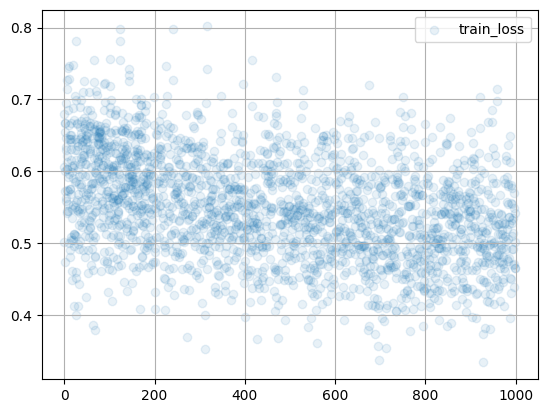

1000it [11:52,  1.40it/s]

Scoring dev...


In [18]:
for i, batch in tqdm(enumerate(train_loader)):
    if i==1000:
      break
    loss_batch = compute_loss(model_FC, batch)

    opt.zero_grad()
    loss_batch.backward()
    opt.step()

    train_history.append((i, float(loss_batch)))
    # train_acc_history.append((i, model_accuracy(model_FC, train_loader)))
    if (i + 1) % 100 == 0:
        clear_output(True)

        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')

        plt.legend(); plt.grid(); plt.show()

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        # val_acc_history.append((i, model_accuracy(model_FC, val_loader)))
        # print('#%i Dev loss: %.3f' % val_acc_history[-1])

In [19]:
model_accuracy(model_FC, val_loader)

100%|██████████| 1264/1264 [05:33<00:00,  3.79it/s]


tensor(0.7605)